## Classiq's YQuantum 2024 Sparse State-Preparation Challenge

Welcome to the Sparse State-Preparation Challenge, presented by Classiq at YQuantum 2024. This challenge is designed for quantum computing enthusiasts of all levels, aiming to enhance your understanding and spur innovation in sparse state-preparation.

### Challenge Overview
- **Objective**: Develop quantum circuits that efficiently prepare sparse quantum states. These states are characterized by a small number of non-zero amplitudes, reducing quantum resource requirements and enhancing practical execution on near-term quantum hardware.

### Background
- **Importance of State Preparation**: State preparation is a crucial first step for many quantum algorithms. It involves setting a quantum state to represent a specific vector of probabilities or functions. The challenge focuses on sparse states, which are pivotal in applications like quantum linear algebra and quantum machine learning.

### Problem Statement
- **Sparse State-Preparation**: Your task is to create circuits that load a quantum state with probabilities corresponding to a given sparse vector. This challenge highlights the nuances of designing circuits that are both efficient and effective for today's quantum computing limitations.

### Resources and Guidance
- **Classiq's Tools**: Utilize Classiq’s platform, QMOD language, and SDK, which provide robust tools for designing and testing quantum algorithms. Participants are encouraged to base their implementations on "An Efficient Algorithm for Sparse Quantum State Preparation" by Niels Gleinig and Torsten Hoefler.

### Goals and Expectations
- **Output Goal**: Efficiently prepare a quantum state reflecting specified probabilities, ensuring high fidelity and resource efficiency. 
- **Example**: For input `{‘00000001’: 0.25, ‘00010001’: 0.5, ‘11001000’: 0.25}`, the output quantum state should correspond to these probabilities.


In [98]:
import classiq
classiq.authenticate()

In [99]:
from classiq import *
import numpy as np

## Classical Functions
This section includes utility functions for classical pre-processing in quantum algorithms:

- `dict_to_3d_array(sparse_states)`: Converts a dictionary of sparse states into a 3D array format.
- `custom_filter(func, iterable)`: Filters items in an iterable based on a function.
- `unequal_sets(t, n)`: Determines the best qubit to split a set `t` into subsets with a significant size difference.
- `process_subsets(t, n, dif_qubits, dif_values)`: Processes subsets to determine difference qubits and values.
- `toggle_operations(index, n, x_x, ops1, ops2, s)`: Toggles operations based on the index condition.
- `conditional_toggle(ops1, ops2, n, dif, b, s)`: Conditionally toggles based on a difference.
- `calc_alpha_beta(x_1, x_2)`: Calculates and adjusts alpha and beta values.

In [105]:
def dict_to_3d_array(sparse_states):
    array_3d = []
    
    for key, value in sparse_states.items():
        point = [int(digit) for digit in key]
        array_3d.append([point, value])
    
    return array_3d

def custom_filter(func, iterable):
    return [item for item in iterable if func(item)]

def unequal_sets(t, n): 

    best_qubit = None
    T_0=[]
    T_1=[]
    current_difference = float('-inf')

    for b in range(n):    
        #Filter list based on boolean condition
        T_0 = custom_filter(lambda x, b=b: x[0][b] == 0, t)
        T_1 = custom_filter(lambda x, b=b: x[0][b] == 1, t)

        # Check if both sets are non-empty
        if len(T_0) != 0 and len(T_1) != 0:
            difference = abs(len(T_0) - len(T_1))
            #If new max difference
            if difference > current_difference:
                current_difference = difference
                best_qubit = b
                t_0 = T_0
                t_1 = T_1
    
    return best_qubit, t_0, t_1

def process_subsets(t, n, dif_qubits, dif_values):
    while len(t) > 1:
        b, T_0, T_1 = unequal_sets(t, n)
        dif_qubits.append(b)
        if len(T_0) < len(T_1):
            t = T_0
            dif_values.append(0)
        else:
            t = T_1
            dif_values.append(1)
    return dif_qubits, dif_values, t

def toggle_operations(index, n, x_x, ops1, ops2, s):
    if x_x[0][index] != 1: #Identical code
            ops1 += [1] # 1 corresponds to NOT gate
            ops2 += [n-1-index] # target of gate (indexed from right)
            for x in s:
                x[0][index]= int(not x[0][index]) # NOT

def conditional_toggle(ops1,ops2,n,dif,b,s):
    ops1 += [2] # 2 corresponds to CNOT gate
    sx = [n-1-dif,n-1-b] 
    ops2 += [sx] # (control, target) 
    for x in s:
        if x[0][dif] == 1:
            x[0][b] = int(not x[0][b])

def calc_alpha_beta(x_1,x_2):
    # we need to do that because in general alpha + beta != 1
    beta = x_1[1]
    alpha = x_2[1]

    x_2[1] = alpha+beta # x_2 is the guy that we keep in the end (toss x_1)
    alpha = alpha/x_2[1]
    beta = beta/x_2[1]

    return alpha, beta

# these methods were added to translate between python indexing and QMOD indexing
def flip_index(index, n):
    return n-1-index

def flip_index_list(l, n):
    return [flip_index(i, n) for i in l]

## Quantum Functions
This section details quantum operations essential for the algorithm:

- Quantum functions corresponding to the classical ones, allowing operations on quantum states based on classical pre-processing.

In [101]:
#TODO implement unitary_control() using Classiq's built in control()
@qfunc
def unitary_control(qubit: QArray[QBit], contrl: QArray[QBit], target: QParam[int]):
      control(lambda: X(qubit[target]), contrl)
#TODO implement y_rotation using the RY() gate
@qfunc
def y_rotation(theta: QParam[float], reg: QArray[QBit], target: QParam[int]):
      RY(theta, reg[target])

@qfunc
def my_controlled_unitary(q:QArray[QBit], w:QParam[float], ctrl:QArray[QBit], target:QParam[int]) -> None:
      within_apply(compute=lambda: y_rotation(w,q,target), action=lambda: unitary_control(q, ctrl, target))

@qfunc
def my_unitary(q:QArray[QBit], w:QParam[float],target:QParam[int]) -> None:
      within_apply(compute=lambda: y_rotation(w,q,target), action=lambda: X(q[target]))

## Sparse State Prep
Describes the arguments and setup for preparing a sparse quantum state:

- Initial setup includes defining quantum bit requirements and preparing the environment.
- Integration of classical functions to set up and manipulate quantum state preparation based on given sparse states.

### Algorithm 1
- **Purpose**: The primary function of `algorithm_1` is to efficiently prepare a sparse quantum state based on a given set of sparse state descriptions. It utilizes classical pre-processing to determine the optimal sequence of quantum gates.
- **Process**:
  - It begins by identifying the qubits and the operations that will result in the greatest simplification of the quantum state based on the input data.
  - The algorithm iteratively processes subsets of quantum states, toggling qubits and adjusting their probabilities to converge towards the desired sparse state.
  - Each iteration updates operation lists which are used to guide the quantum operations on the actual quantum hardware.
  

In [106]:
def algorithm_1(s,n, ops1, ops2, ops3, ops4, ops5, n9):
    dif_qubits = [] #Where to operate
    dif_values = [] #What operation

    #Preprocessing
    T = s

    dif_qubits, dif_values, t = process_subsets(T, n, dif_qubits, dif_values)
            
    dif = dif_qubits.pop()
    dif_values.pop()

    x_1 = t[0]
    t_dagger = [x for x in s if all(x[0][q] == v for q, v in zip(dif_qubits, dif_values))]
    t_dagger.remove(x_1)

        

    dif_qubits, dif_values, t_dagger = process_subsets(t_dagger, n, dif_qubits, dif_values)        
            
    x_2 = t_dagger[0]


    #Storing necessary operations
    toggle_operations(dif,n,x_1,ops1,ops2,s)
            
    for b in range(n):
        if b != dif and x_1[0][b] != x_2[0][b]:
            conditional_toggle(ops1,ops3,n,dif,b,s)

    for b in dif_qubits:
        toggle_operations(b,n,x_2,ops1,ops2,s)
        

    alpha, beta = calc_alpha_beta(x_1,x_2)
    
    ops1 += [3]
    #sy = [alpha, beta, dif_qubits, dif]
    # store location of G gate with flipped indices
    sy = [alpha, beta, flip_index_list(dif_qubits, n), flip_index(dif, n)]

    if len(dif_qubits) > 0:
        n9 += [len(dif_qubits)]
    else:
        sy.remove(dif_qubits)

    ops4 += [sy]
    s.remove(x_1) # we can remove x_1 because x_1[0] = x_2[0] and we already set x_2[1] = alpha + beta

    if len(s) > 1:
        algorithm_1(s,n, ops1, ops2, ops3, ops4, ops5, n9)
    else:
        ops1 += [4]
        ops5 += [x_2[0]]

### Main Function Implementation
- **Purpose**: The `main` function orchestrates the overall setup and execution of the sparse state preparation.
- **Functionality**:
  - It initializes the quantum environment with the necessary number of qubits based on the input state descriptions.
  - The sparse states are first converted into a format suitable for quantum operations using `dict_to_3d_array`.
  - The main function then invokes `algorithm_1` to find the necessary operation to prepare the sparse quantum state.
  - After `algorithm_1` completes, the `main` function applies the quantum operations to finalize the state preparation.
  - It is responsible for managing and applying the computed operations to the quantum system, effectively translating the classical pre-processing results into quantum manipulations.

In [156]:
# These are helper function that split the register into 2 or 3 parts
# depending on the position of the control qubit
@qfunc
def LeftControl(psi: QArray[QBit], theta: QParam[float], target: QParam[int], NUM_QUBITS: QParam[int]):
    """Call this function if the control qubit is on the far left of the chain"""
    ctr = QBit("ctr")
    leftover = QArray("leftover", QBit, NUM_QUBITS-1)
    bind(psi, [ctr, leftover])
    # if theta == 0: apply a CNOT, if not: apply R_y(-theta)*CNOT*R_y(theta)
    if_(
        condition=(theta == 0),
        then=lambda : unitary_control(leftover,ctr,target-1),
        else_=lambda : my_controlled_unitary(leftover, theta, ctr, target-1),
    )
    bind([ctr, leftover], psi)

@qfunc
def RightControl(psi: QArray[QBit], theta: QParam[float], target: QParam[int], NUM_QUBITS: QParam[int]):
    """Call this function if the control qubit is on the far right of the chain"""
    ctr = QBit("ctr")
    leftover = QArray("leftover", QBit, NUM_QUBITS-1)
    bind(psi, [leftover, ctr])
    # if theta == 0: apply a CNOT, if not: apply R_y(-theta)*CNOT*R_y(theta)
    if_(
        condition=(theta == 0),
        then=lambda : unitary_control(leftover,ctr,target),
        else_=lambda : my_controlled_unitary(leftover, theta, ctr, target),
    )
    bind([leftover, ctr], psi)

@qfunc
def LLControl(psi: QArray[QBit], theta: QParam[float], target: QParam[int], NUM_QUBITS: QParam[int], dq: QParam[int]):
    """Call this function if the control qubit is in the bulk of the chain and the target is 
    on the left of the control qubit"""
    ctr = QBit("ctr")
    leftoverL = QArray("leftoverL", QBit, dq)
    leftoverCtrR = QArray("leftoverCtrR", QBit, NUM_QUBITS-dq)
    leftoverR = QArray("leftoverR", QBit, NUM_QUBITS-dq-1)
    bind(psi, [leftoverL, leftoverCtrR])
    bind(leftoverCtrR, [ctr, leftoverR])
    # if theta == 0: apply a CNOT, if not: apply R_y(-theta)*CNOT*R_y(theta)
    if_(
        condition=(theta == 0),
        then=lambda : unitary_control(leftoverL,ctr,target),
        else_=lambda : my_controlled_unitary(leftoverL, theta, ctr, target),
    )
    bind([ctr, leftoverR], leftoverCtrR)
    bind([leftoverL, leftoverCtrR], psi)

@qfunc
def RRControl(psi: QArray[QBit], theta: QParam[float], target: QParam[int], NUM_QUBITS: QParam[int], dq: QParam[int]):
    """Call this function if the control qubit is in the bulk of the chain and the target is 
    on the right of the control qubit"""
    ctr = QBit("ctr")
    leftoverL = QArray("leftoverL", QBit, dq)
    leftoverCtrR = QArray("leftoverCtrR", QBit, NUM_QUBITS-dq)
    leftoverR = QArray("leftoverR", QBit, NUM_QUBITS-dq-1)
    bind(psi, [leftoverL, leftoverCtrR])
    bind(leftoverCtrR, [ctr, leftoverR])
    # if theta == 0: apply a CNOT, if not: apply R_y(-theta)*CNOT*R_y(theta)
    if_(
        condition=(theta == 0),
        then=lambda : unitary_control(leftoverL,ctr,target-1-dq),
        else_=lambda : my_controlled_unitary(leftoverR, theta, ctr, target-1-dq),
    )
    bind([ctr, leftoverR], leftoverCtrR)
    bind([leftoverL, leftoverCtrR], psi)

def count_gates(ops1, ops5):
    num_gates = 0
    for op in ops1:
        if op == 1 or op == 2:
            num_gates += 1
        elif op == 3:
            num_gates += 3
    for x in ops5:
        num_gates += sum(x)
    return num_gates

In [193]:
@qfunc
def main(psi: Output[QArray[QBit]]):
    

    #Arguments for algorithm1()
    sparse_states = {'00000000000000000101': 0.6, '00000000000000010001': 0.4}

    NUM_QUBITS = len(next(iter(sparse_states)))

    ops1 = [] #Stores operations
    ops2 = [] #Stores position of NOT gates
    ops3 = [] #Stores (control, target) of CNOT
    ops4 = [] #Stores (alpha, beta, dif_qubits, dif) for G gate
    ops5 = [] #Stores bitmap for NOT gates
    n9 = []
    
    #End of arguments
    #Allocate qubits for output
    allocate(NUM_QUBITS, psi)

    sparse_states = dict_to_3d_array(sparse_states)
    if len(sparse_states[0]) > 1:
        #Reference https://htor.inf.ethz.ch/publications/img/quantum_dac.pdf to understand algorithm_1() and its relationship to implementation
        algorithm_1(sparse_states, NUM_QUBITS, ops1, ops2, ops3, ops4, ops5, n9)
        #TODO YOUR CODE HERE

        CIRCUIT_DEPTH = count_gates(ops1, ops5)
        
        # DEBUG CORNER
        print("Circuit depth: ", CIRCUIT_DEPTH)
        # print(ops1, ops2, ops3, ops4, ops5)
        # DEBUG CORNER
        
        #Finish implementation to prepare sparse quantum state for psi
        N = len(ops1)
        # The counters keep track of how often each gate appears
        counter1 = 0
        counter2 = 0
        counter3 = 0
        counter4 = 0
        for i in range(1, N+1):
            # iterate through the list backwards!
            if ops1[-i] == 4:
                # place NOT gates according to bitmap
                for (index, val) in enumerate(ops5[-1-counter4]):
                    if val == 1:
                        X(psi[NUM_QUBITS-index-1])
                counter4 += 1
            if ops1[-i] == 3:
                # place G gates
                if len(ops4[-1-counter3]) == 4:
                    # in case dif_qubits is nonempty
                    alpha, beta, dif_qubits, dif = ops4[-1-counter3]
                    theta = np.arctan(np.sqrt(alpha/beta))
                    for dq in dif_qubits:
                        if dq == 0:
                            LeftControl(psi, theta, dif, NUM_QUBITS)
                        elif dq == NUM_QUBITS-1:
                            RightControl(psi, theta, dif, NUM_QUBITS)
                        else:
                            if dq > dif:
                                LLControl(psi, theta, dif, NUM_QUBITS, dq)
                            else:
                                RRControl(psi, theta, dif, NUM_QUBITS, dq)
                else: 
                    # in case dif_qubits is empty
                    alpha, beta, dif = ops4[-1-counter3]
                    theta = np.arctan(np.sqrt(alpha/beta))
                    my_unitary(psi, theta, dif)
                counter3 += 1
            if ops1[-i] == 2:
                # place CNOT gates which are just G gates for theta=0
                ctr, target = ops3[-1-counter2]
                if ctr == 0:
                    LeftControl(psi, 0, target, NUM_QUBITS)
                elif ctr == NUM_QUBITS-1:
                    RightControl(psi, 0, target, NUM_QUBITS)
                else:
                    if ctr > target:
                        LLControl(psi, 0, target, NUM_QUBITS, ctr)
                    else:
                        RRControl(psi, 0, target, NUM_QUBITS, ctr)
                counter2 += 1
            if ops1[-i] == 1:
                # Place the NOT gates at given position
                X(psi[ops2[-1-counter1]])
                counter1 +=1

        #TODO YOUR CODE ENDS HERE
    else:
         for b in range(NUM_QUBITS):
            if sparse_states[0][0][b]==1:
                X(psi[NUM_QUBITS-1-b])

model = create_model(main)
qprog = synthesize(model)
show(qprog)

Circuit depth:  6
Opening: https://platform.classiq.io/circuit/35960b4a-d2d2-4146-a335-4079602acb9d?version=0.39.0


In [176]:
# BENCHMARK
@qfunc
def main(psi: Output[QArray[QBit]]):
    sparse_states = {'000011': 0.4, '111111': 0.6}
    NUM_QUBITS = len(next(iter(sparse_states)))
    p = np.zeros(2**NUM_QUBITS)
    for (key, val) in sparse_states.items():
        p[int(key, 2)] = val
    p = list(p)
    prepare_state(probabilities=p, bound=0.1, out=psi)
    
    
model = create_model(main)
qprog = synthesize(model)
show(qprog)

Opening: https://platform.classiq.io/circuit/62f91de6-c254-4e68-b336-4f326326ec0b?version=0.39.0


## Good Luck!

HINT: If you are getting inconsistent results when running code cells repeatedly, run all cells at once or restart your notebook kernel.

In [184]:
import matplotlib.pyplot as plt
N_states = [2, 3, 4, 5]

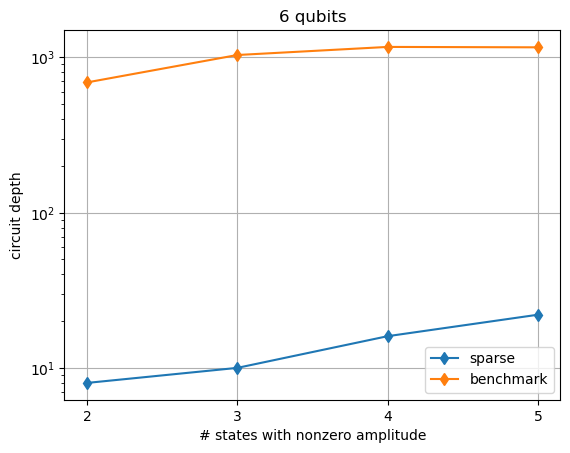

In [186]:
c_depth6_sparse = [8, 10, 16, 22]
c_depth6_benchmark = [690, 1036, 1168, 1161]
plt.plot(N_states, c_depth6_sparse, label="sparse", marker="d")
plt.plot(N_states, c_depth6_benchmark, label="benchmark", marker="d")
plt.xlabel("# states with nonzero amplitude")
plt.ylabel("circuit depth")
plt.xticks([2, 3, 4, 5], [2, 3, 4, 5])
plt.grid()
plt.yscale("log")
plt.legend()
plt.title("6 qubits")
plt.savefig("6q.png", dpi=300)

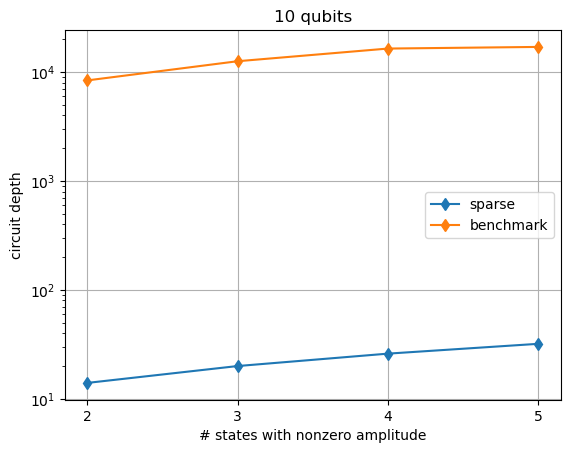

In [187]:
c_depth10_sparse = [14, 20, 26, 32]
c_depth10_benchmark = [8395, 12593, 16464, 17045]
plt.plot(N_states, c_depth10_sparse, label="sparse", marker="d")
plt.plot(N_states, c_depth10_benchmark, label="benchmark", marker="d")
plt.xlabel("# states with nonzero amplitude")
plt.ylabel("circuit depth")
plt.xticks([2, 3, 4, 5], [2, 3, 4, 5])
plt.grid()
plt.yscale("log")
plt.legend()
plt.title("10 qubits")
plt.savefig("10q.png", dpi=300)

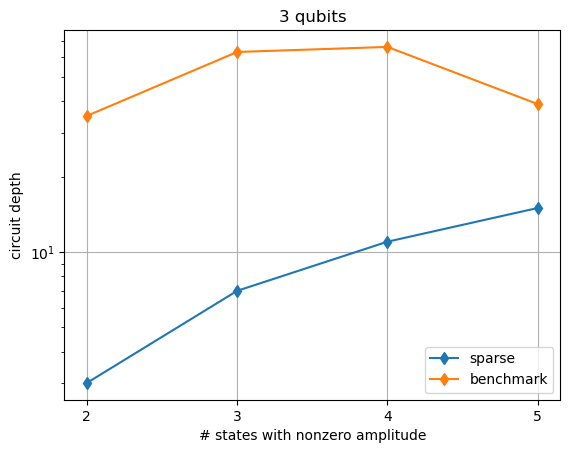

In [189]:
c_depth3_sparse = [3, 7, 11, 15]
c_depth3_benchmark = [35, 63, 66, 39]
plt.plot(N_states, c_depth3_sparse, label="sparse", marker="d")
plt.plot(N_states, c_depth3_benchmark, label="benchmark", marker="d")
plt.xlabel("# states with nonzero amplitude")
plt.ylabel("circuit depth")
plt.xticks([2, 3, 4, 5], [2, 3, 4, 5])
plt.grid()
plt.yscale("log")
plt.legend()
plt.title("3 qubits")
plt.savefig("3q.png", dpi=300)

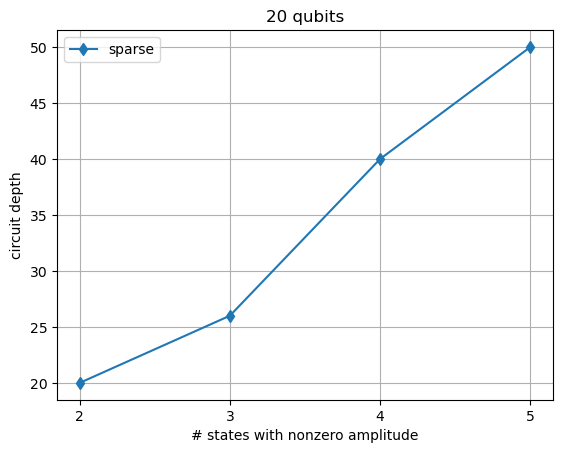

In [190]:
c_depth20_sparse = [20, 26, 40, 50]
plt.plot(N_states, c_depth20_sparse, label="sparse", marker="d")
plt.xlabel("# states with nonzero amplitude")
plt.ylabel("circuit depth")
plt.xticks([2, 3, 4, 5], [2, 3, 4, 5])
plt.grid()
# plt.yscale("log")
plt.legend()
plt.title("20 qubits")
plt.savefig("20q.png", dpi=300)